In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import root_mean_squared_error
from reservoirpy.datasets import mackey_glass
import pandas as pd
import pickle
from datetime import datetime
import seaborn as sns

import os.path as osp
from glob import glob

In [2]:
import wfdb
from wfdb import processing

# Download a sample record from the MIT-BIH Arrhythmia Database
record_name = '100'
#wfdb.dl_database('mitdb', './mitdb')

# Read the ECG signal and annotation from the dataset
record = wfdb.rdrecord(f'./mitdb/{record_name}')
annotation = wfdb.rdann(f'./mitdb/{record_name}', 'atr')

# Extracting the signal (ECG data)
ecg_signal = record.p_signal

# Display some information
print(f"Signal shape: {ecg_signal.shape}")
print(f"Signal sampling rate: {record.fs} Hz")

Signal shape: (650000, 2)
Signal sampling rate: 360 Hz


In [3]:
ecg_dataset=[]
for i in range(100,235):
    record_name = str(i)
    #wfdb.dl_database('mitdb', './mitdb')

    try:
        # Read the ECG signal and annotation from the dataset
        record = wfdb.rdrecord(f'./mitdb/{record_name}')
        annotation = wfdb.rdann(f'./mitdb/{record_name}', 'atr')

        # Extracting the signal (ECG data)
        ecg_signal = record.p_signal

        # Display some information
        ecg_dataset.append(ecg_signal[:, 0])
        ecg_dataset.append(ecg_signal[:, 1])
    except:
        ...

In [4]:
class EchoStateNetwork:
    def __init__(self, n_input, n_reservoir, n_output, spectral_radius=1.25, sparsity=0.1, alpha = 1, noise=0.001, random_state=None):
        """
        Initialize the Echo State Network.
        
        Parameters:
        - n_input: Number of input units.
        - n_reservoir: Number of reservoir neurons.
        - n_output: Number of output units.
        - spectral_radius: Scaling factor for the reservoir weights.
        - sparsity: Fraction of weights set to zero in the reservoir.
        - noise: Amount of noise to add to the reservoir dynamics.
        - random_state: Random seed for reproducibility.
        """
        # just for the random seed
        if random_state is not None:
            np.random.seed(random_state)
        
        self.n_input = n_input
        self.n_reservoir = n_reservoir
        self.n_output = n_output
        self.spectral_radius = spectral_radius
        # this number is used for making the sparsity
        self.sparsity = sparsity
        self.alpha = alpha
        
        # pbbly for the noise ammount
        self.noise = noise

        # Input weight matrix
        self.W_in = np.random.uniform(-1, 1, (n_reservoir, n_input + 1))  # +1 for bias term

        # Reservoir weight matrix (random sparse matrix)
        W_res = np.random.rand(n_reservoir, n_reservoir) - 0.5
        # ah ok so you 0 out every place that has more thant sparsity based on a normaly distributed matrix
        W_res[np.random.rand(*W_res.shape) > sparsity] = 0
        # Rescale to ensure the spectral radius
        rho_W = np.max(np.abs(np.linalg.eigvals(W_res)))
        self.W_res = W_res * (spectral_radius / rho_W)
        
        

        # Output weight matrix (initialized later)
        self.W_out = None
        
    def get_reservoir(self):
        return self.W_res
    
    def get_w_in(self):
        return self.W_in
    
    def set_reservoir(self, res):
        self.W_res = res
    
    def set_w_in(self,w_in):
        self.W_in = w_in

    def _update_reservoir(self, x, r):
        """
        Update the reservoir state.
        
        Parameters:
        - x: Current input.
        - r: Previous reservoir state.
        
        Returns:
        - Updated reservoir state.
        """
        input_with_bias = np.hstack([1.0, x])  # Add bias term to input
        # input_wiht_bias.shape == 1,self.n_input+1 
        # W_in.shape == self.n_reservoir, self.n_input+1
        # np.dot(self.W_in, input_with_bias).shape == self.n_reservoir
        # r_new.shape == self.n_reservoir
        r_new = np.tanh(np.dot(self.W_in, input_with_bias) + np.dot(self.W_res, r))# + self.noise * np.random.randn(self.n_reservoir))

        r_new = ( 1 - self.alpha ) * r + self.alpha * r_new
        return r_new

    def fit(self, X, y, ridge_reg=1e-6):
        """
        Train the output weights using ridge regression.
        
        Parameters:
        - X: Input data (n_samples, n_timesteps, n_features).
        - y: Target data (n_samples, n_timesteps, n_output).
        - ridge_reg: Regularization strength for ridge regression.
        """
        n_samples, n_timesteps, _ = X.shape
        
        # Initialize reservoir states
        reservoir_states = np.zeros((n_samples * n_timesteps, self.n_reservoir))

        # Collect reservoir states
        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                r = self._update_reservoir(X[i, t], r)
                reservoir_states[i * n_timesteps + t] = r

        # Add bias term to reservoir states
        reservoir_states_with_bias = np.hstack([np.ones((reservoir_states.shape[0], 1)), reservoir_states])

        # Flatten target data
        target = y.reshape(-1, self.n_output)

        # Ridge regression to compute output weights
        self.W_out = np.dot(
            np.linalg.pinv(np.dot(reservoir_states_with_bias.T, reservoir_states_with_bias) + ridge_reg * np.eye(reservoir_states_with_bias.shape[1])),
            np.dot(reservoir_states_with_bias.T, target)
        )

    def predict(self, X):
        """
        Predict output for the given input data.
        
        Parameters:
        - X: Input data (n_samples, n_timesteps, n_features).
        
        Returns:
        - Predicted output (n_samples, n_timesteps, n_output).
        """
        n_samples, n_timesteps, _ = X.shape
        predictions = np.zeros((n_samples, n_timesteps, self.n_output))

        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                r = self._update_reservoir(X[i, t], r)
                input_with_bias = np.hstack([1.0, r])  # Add bias term
                predictions[i, t] = np.dot(input_with_bias, self.W_out)

        return predictions
    
    def get_activations(self, X):
        n_samples, n_timesteps, _ = X.shape
        activations = np.zeros((n_samples, n_timesteps, self.n_reservoir+self.n_input+1))

        for i in range(n_samples):
            r = np.zeros(self.n_reservoir)  # Initial reservoir state
            for t in range(n_timesteps):
                
                r = self._update_reservoir2(X[i, t], r)
                inputs = np.hstack([1,X[i,t]]) 
                # I wan't to store these values
                activations[i,t] = np.concatenate([inputs, r])

        return activations
    
# Example usage:

# Initialize ESN
esn = EchoStateNetwork(n_input=1, n_reservoir=100, n_output=1, spectral_radius=1.25, sparsity=0.1, random_state=42)

# Create dummy training data (sine wave)
timesteps = 200
X_train = np.sin(np.linspace(0, 10, timesteps)).reshape(1, timesteps, 1)
y_train = np.cos(np.linspace(0, 10, timesteps)).reshape(1, timesteps, 1)

# Train the ESN
esn.fit(X_train, y_train)

# Predict on the training data
y_pred = esn.predict(X_train)

# Output the first few predictions


In [5]:
def get_signal(signal, offset, shift, window_size, max_val):
    # offset: starting position
    # shift: number of steps to shift the signal
    if window_size+shift < max_val:
        return signal[offset+shift: offset+window_size+shift].reshape(1,-1,1)
    
    return None

In [6]:
def train_on_signal(esn, signal,offset,shift,window_size, signal_len,display=False):
    X_train = get_signal(signal, offset, shift, window_size, signal_len)
    Y_train = get_signal(signal, offset, 0, window_size, signal_len)

    if display:
        plt.plot(X_train.flatten()[:1000],label='x')
        plt.plot(Y_train.flatten()[:1000],label='y')
        plt.legend()
        plt.show()
    
    esn.fit(X_train, Y_train)
    
def test_on_signal(esn, signal, offset, shift, window_size, signal_len, display = False):
    X_test = get_signal(signal, test_offset, shift, window_size, signal_len)
    Y_test = get_signal(signal, test_offset, 0, window_size, signal_len)
    
    Y_pred = esn.predict(X_test)
    
    if display:
        plt.plot(X_test.flatten()[:500],label='x')
        plt.plot(Y_test.flatten()[:500],label='y')
        plt.plot(Y_pred.flatten()[:500],label='y_pred')
        plt.ylim(-2,2)
        plt.legend()
        plt.show()
    
    return root_mean_squared_error(Y_pred.flatten(), Y_test.flatten()), Y_pred.flatten()

In [7]:
def get_gt(signal,offset,shift,window_size):
    X_train = get_signal(signal, offset, shift, window_size, len(signal))
    Y_train = get_signal(signal, offset, 0, window_size, len(signal))
    return X_train, Y_train

In [8]:
#ln = X_train.shape[0]
#index = list(range(ln))
#np.random.shuffle(index)
#train_index = index[:56]
#rest_index = index[56:]
#val_index = rest_index[:20]
#test_index = rest_index[20:]

In [9]:
#with open('train_index.npy', 'wb') as f:
#    np.save(f, train_index)
#    
#with open('val_index.npy', 'wb') as f:
#    np.save(f, val_index)
#    
#with open('test_index.npy', 'wb') as f:
#    np.save(f, test_index)


In [10]:
def mean_rmse(pred, ground_truth):
    total = 0
    for j,k in zip(pred,ground_truth):
        total += root_mean_squared_error(j.flatten(),k.flatten())
    return total/len(pred)

In [11]:
def create_ecg_dataset(ecg_dataset,shift,window_size,offset=0):
    X_data = []
    Y_data = []
    for ecg in ecg_dataset:
        x_data, y_data = get_gt(ecg,offset,shift,window_size)
        X_data.append(x_data)
        Y_data.append(y_data)
        
    X_data = np.vstack(X_data).reshape(len(ecg_dataset),-1,1)
    Y_data = np.vstack(Y_data).reshape(len(ecg_dataset),-1,1)
    
    train_index = np.load('train_index.npy')
    val_index = np.load('val_index.npy')
    test_index = np.load('test_index.npy')
    
    X_train = X_data[train_index]
    Y_train = Y_data[train_index]
    
    X_val = X_data[val_index]
    Y_val = Y_data[val_index]
    
    X_test = X_data[test_index]
    Y_test = Y_data[test_index]
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [12]:
def get_feature_vectors(X, esn):
    result = esn.get_activations(X)
    arr = result[0].reshape(125,16,18)
    return arr.mean(axis=1).T

In [13]:
def create_reservoirs(n_res_samples, n_reservoir, alpha, sparsity_a, sparsity_b, sr_a, sr_b ):
    results = {'mean_rmse':[],'reservoir':[],'w_in':[], 'activations':[]}

    for i in range(n_res_samples):
        spectral_radius = np.random.uniform(sr_a,sr_b)
        sparsity = np.random.uniform(sparsity_a,sparsity_b)
        esn = EchoStateNetwork(n_input=1, n_reservoir=n_reservoir, n_output=1, spectral_radius=spectral_radius, alpha = alpha, sparsity=sparsity)
        esn.fit(X_train,Y_train)
        res = esn.predict(X_val)
        score = mean_rmse(res,Y_val)
        results['mean_rmse'].append(score)
        results['reservoir'].append(esn.get_reservoir())
        results['w_in'].append(esn.get_w_in())
        
        results['feature_vectors'].append(get_feature_vectors(X_val[1], esn))
        
    return results

In [14]:
def spectral_radius(W_res):
    return np.max(np.abs(np.linalg.eigvals(W_res)))

In [15]:
def test_reservoir(w_in, w_res, X_train, Y_train, X_val, Y_val):
    spectral_radius = 1 # not important just for the model initialization
    sparsity = 0.2 # not important just for the model initialization
    
    alpha = 0.35 # important to keep it the same which in our case was 0.35
    n_reservoir = w_in.shape[0]
    esn = EchoStateNetwork(n_input=1, n_reservoir=n_reservoir, n_output=1, spectral_radius=1, alpha = alpha, sparsity=0.2)
    
    esn.set_w_in(w_in)
    esn.set_reservoir(w_res)
    esn.fit(X_train, Y_train)
    
    res = esn.predict(X_val)
    score = mean_rmse(res,Y_val)
    return score

# Creating ECG Dataset

In [16]:
shift = 12
window_size = 2000
X_train, Y_train, X_val, Y_val, X_test, Y_test = create_ecg_dataset(ecg_dataset,shift, window_size)

# IDD

In [47]:
# load the sampled reservoirs

file_paths = glob('reservoir_data/graph_vae/wrong_matching/*_idd_samples.pkl')
idd_storage = dict()

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        file_data = pickle.load(f)
        
    name = file_path.split('/')[-1].split('_')[0]
        
    file_data_res = []
    for idx, data in enumerate(file_data):
        w_in = data[1]
        w_res = data[2]

        score = test_reservoir(w_in,w_res,X_train,Y_train,X_val,Y_val)

        file_data_res.append(data + [score,spectral_radius(w_res)])
    idd_storage[name] = file_data_res

In [48]:
out_file_path = 'reservoir_data/graph_vae/wrong_matching/idd_results.pkl'
with open(out_file_path, 'wb') as f:
    pickle.dump(idd_storage,f)

In [55]:
print(storage['res16'][0][3])
print(storage['res16'][0][4])

0.06343412747000478
0.17963581


# ODD

In [17]:
file_paths = glob('reservoir_data/graph_vae/wrong_matching/*_odd_samples.pkl')
odd_storage = dict()

for file_path in file_paths:
    with open(file_path, 'rb') as f:
        file_data = pickle.load(f)
        
    name = file_path.split('/')[-1].split('_')[0]
        
    all_odd_res = []
    for outliers in file_data:
        file_data_res = []
        for idx, data in enumerate(outliers[1]):
            w_in = data[1]
            w_res = data[2]
            score = test_reservoir(w_in,w_res,X_train,Y_train,X_val,Y_val)
            file_data_res.append(data + [score,spectral_radius(w_res)])
        
        all_odd_res.append(file_data_res)

    odd_mrmse_results = []
    for idx, outliers in enumerate(all_odd_res):
        for data in outliers:
            ## idx, radius, mrmse, spectral_radius
            odd_mrmse_results.append([idx, file_data[idx][0]/1000, data[3], data[4]])
            
    odd_storage[name]= odd_mrmse_results
            

In [19]:
odd_storage

{'res23': [[0, 3.570962934494018e-05, 0.04545570830461402, 0.30695954],
  [0, 3.570962934494018e-05, 0.04540430885406984, 0.305754],
  [0, 3.570962934494018e-05, 0.04542752228889138, 0.3076259],
  [0, 3.570962934494018e-05, 0.045454325895693884, 0.3066693],
  [0, 3.570962934494018e-05, 0.04539960314922063, 0.3059102],
  [0, 3.570962934494018e-05, 0.04540165192042511, 0.30684656],
  [0, 3.570962934494018e-05, 0.0454627452106377, 0.3074862],
  [0, 3.570962934494018e-05, 0.04544387712589545, 0.30599144],
  [0, 3.570962934494018e-05, 0.04547533781798228, 0.30678344],
  [0, 3.570962934494018e-05, 0.0454494610283497, 0.30632693],
  [0, 3.570962934494018e-05, 0.045501599811251445, 0.30467904],
  [0, 3.570962934494018e-05, 0.04544897554032636, 0.30615065],
  [0, 3.570962934494018e-05, 0.0454237689101145, 0.3066656],
  [0, 3.570962934494018e-05, 0.04539254537391606, 0.30589506],
  [0, 3.570962934494018e-05, 0.045412288559687326, 0.30584612],
  [0, 3.570962934494018e-05, 0.045452460472502745, 0.

In [20]:
out_file_path = 'reservoir_data/graph_vae/wrong_matching/odd_results.pkl'
with open(out_file_path, 'wb') as f:
    pickle.dump(odd_storage,f)

# Load the training reservoirs and compare them

In [1]:
from utils import load_all_reservoirs


/home/volta/Documents/ucph/Thesis/thesis_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_data = load_all_reservoirs('reservoir_data/res_16_more_info/')

In [7]:
file_path = 'reservoir_data/res_16_results'
with open ( file_path, 'rb') as f:
    data = pickle.load(f)

In [24]:
percentile = np.percentile(all_data['mean_rmse'],14)
mask = all_data['mean_rmse'] < percentile

In [15]:
mrmse_generated = []
for i in data:
    mrmse_generated.append(i[3])

In [16]:
mrmse_generated

[0.04822165504402255,
 0.04821009682320227,
 0.04829201258588253,
 0.04832143196017244,
 0.04830510134963635,
 0.04821041576037667,
 0.04817623692208563,
 0.04829730901509584,
 0.04822966805612648,
 0.0483435111322099,
 0.048279455976778615,
 0.04823545508240819,
 0.048211909636201915,
 0.04829162768719018,
 0.048226460043166816,
 0.04837210458497053,
 0.04814948594267261,
 0.048344584641319965,
 0.048180607746483244,
 0.048173745065640115,
 0.04831405424926707,
 0.048224998664137556,
 0.04829023259801386,
 0.048282852524083666,
 0.048219580117493645,
 0.04824836814379269,
 0.04819912851276588,
 0.04823905925205628,
 0.048237230036395226,
 0.04819461800904181,
 0.0482544345640818,
 0.048303099478223616,
 0.0481898993540205,
 0.04824778306460633,
 0.04825731076735979,
 0.04828031750142666,
 0.04832139264663042,
 0.048286625850926204,
 0.04827624934377504,
 0.0482314362119729,
 0.04826593984916337,
 0.04824786474260648,
 0.0482597864171936,
 0.04827857951336354,
 0.04821016922361997,
 0.

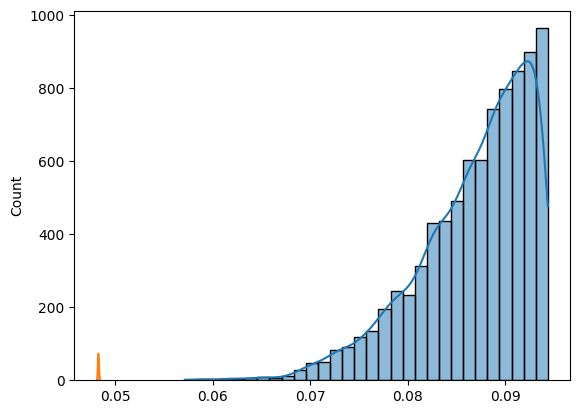

In [29]:
sns.histplot(np.array(all_data['mean_rmse'])[mask],bins=30,kde=True)
sns.histplot(mrmse_generated,bins=30,kde=True)
plt.show()

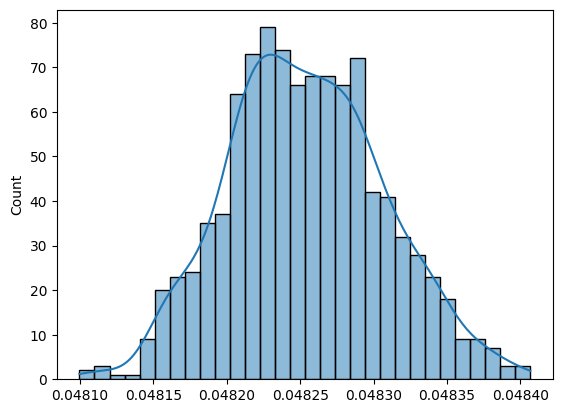

In [20]:
sns.histplot(mrmse_generated,bins=30,kde=True)
plt.show()

# Statistical Test

In [23]:
import scipy.stats as stats

A = np.array(all_data['mean_rmse'])[mask]
B = mrmse_generated
t_statistic, p_value = stats.ttest_ind(A,B,equal_var=False)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

alpha = 0.01
degrees_of_freedom = len(A) + len(B) - 2
critical_value = stats.t.ppf(1 - alpha, degrees_of_freedom)

if t_statistic > critical_value and p_value < alpha:
    print("Reject the null hypothesis.")
    print("Conclusion: There is sufficient evidence to suggest that the sampled reservoirs are better than randomly generated")
else:
    print("Fail to reject the null hypothesis.")
    print("Conclusion: There is not enough evidence to suggest that the sampled reservoirs leads to better results")

t-statistic: 764.1292232828963
p-value: 0.0
Reject the null hypothesis.
Conclusion: There is sufficient evidence to suggest that the sampled reservoirs are better than randomly generated
